In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.cluster import KMeans
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", module="statsmodels")
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('/content/USvideos.csv')
all_category = pd.read_json('/content/US_category_id.json')
for i in range(3):
  print(all_category['items'][i])

{'kind': 'youtube#videoCategory', 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKmPBggty2mZQ"', 'id': '1', 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'title': 'Film & Animation', 'assignable': True}}
{'kind': 'youtube#videoCategory', 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/UZ1oLIIz2dxIhO45ZTFR3a3NyTA"', 'id': '2', 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'title': 'Autos & Vehicles', 'assignable': True}}
{'kind': 'youtube#videoCategory', 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/nqRIq97-xe5XRZTxbknKFVe5Lmg"', 'id': '10', 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'title': 'Music', 'assignable': True}}


# Data Preprocessing

In [3]:
# Reomve error videos
df = df[df['video_error_or_removed'] == False].copy()

# Identify rows with '#NAME?' video_id (missing video_id)
problem_rows = df[df['video_id'] == '#NAME?']

# Create a new identifier for these rows
new_ids = problem_rows.apply(lambda row: f"{row['title']}_{row['category_id']}", axis=1)

# Update the 'video_id' column for the problematic rows
df.loc[problem_rows.index, 'video_id'] = new_ids

# Feature engineering
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df['trending_year'] = df['trending_date'].dt.year
df['trending_month'] = df['trending_date'].dt.month
df['trending_dayofweek'] = df['trending_date'].dt.dayofweek
df['publish_hour'] = df['publish_time'].dt.hour
df['time_takes_to_trending'] = df['trending_date'] - df['publish_time'] + pd.Timedelta(hours=12)
df['time_takes_to_trending'] = df['time_takes_to_trending'].apply(lambda x: max(x, pd.Timedelta(hours=12)))
df["time_cut"]=pd.cut(df["time_takes_to_trending"].dt.days,[-2,1,3,5,7,36500],labels=["0-1 days","1-3 days","3-5 days","5-7 days","7+ days"])
# df['views_per_like'] = np.where(df['likes'] > 0, df['views'] / df['likes'], 0)
category_ids = {int(all_category['items'][i]['id']):all_category['items'][i]['snippet']['title'] for i in range(len(all_category))}
df.insert(5, 'category', df['category_id'].map(category_ids))

In [4]:
# Outlier removal for cleaning purposes
X = df[['likes', 'dislikes', 'comment_count']]
y = df[['views']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regr_rf_final = RandomForestRegressor(random_state=42)
regr_rf_final.fit(X_train, y_train.reshape(-1, 1))
y_pred_rf_final = regr_rf_final.predict(X)

normalized_error = (y - y_pred_rf_final) / np.sqrt(mean_squared_error(y, y_pred_rf_final))
# remove outliers based on domain expertise
outliers = np.abs(normalized_error) > 1
cleaned_X = X[~outliers]
cleaned_y = y[~outliers]
regr_rf_final.fit(cleaned_X, cleaned_y)
y_pred_rf_final_cleaned = regr_rf_final.predict(cleaned_X)
print(f'MSE: {mean_squared_error(cleaned_y, y_pred_rf_final_cleaned)}')
print(f'R2 Score: {r2_score(cleaned_y, y_pred_rf_final_cleaned)}')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE: 105605093545.68736
R2 Score: 0.9957372000990905


In [5]:
# Preprocess data for time-series analysis
df2 = pd.read_csv('/content/USvideos.csv')
df2 = df2[df2['video_error_or_removed'] == False].copy()
df2 = df2[~outliers]
data = df2

# Convert trending_date from 'yy.dd.mm' format to datetime
data['trending_date'] = pd.to_datetime(data['trending_date'], format='%y.%d.%m')
data['trending_year'] = data['trending_date'].dt.year
data['trending_month'] = data['trending_date'].dt.month

# Define reference date using datetime
reference_date = df['trending_date'].min()

# Compute days since reference date
data['days_since_start'] = (data['trending_date'] - reference_date).dt.days

# for the purpose of accessing categories
combined_df = df.sort_values('category_id', inplace=False).groupby(['category_id', 'category']).agg({'views':['sum', 'mean']}).reset_index()

# ARIMA

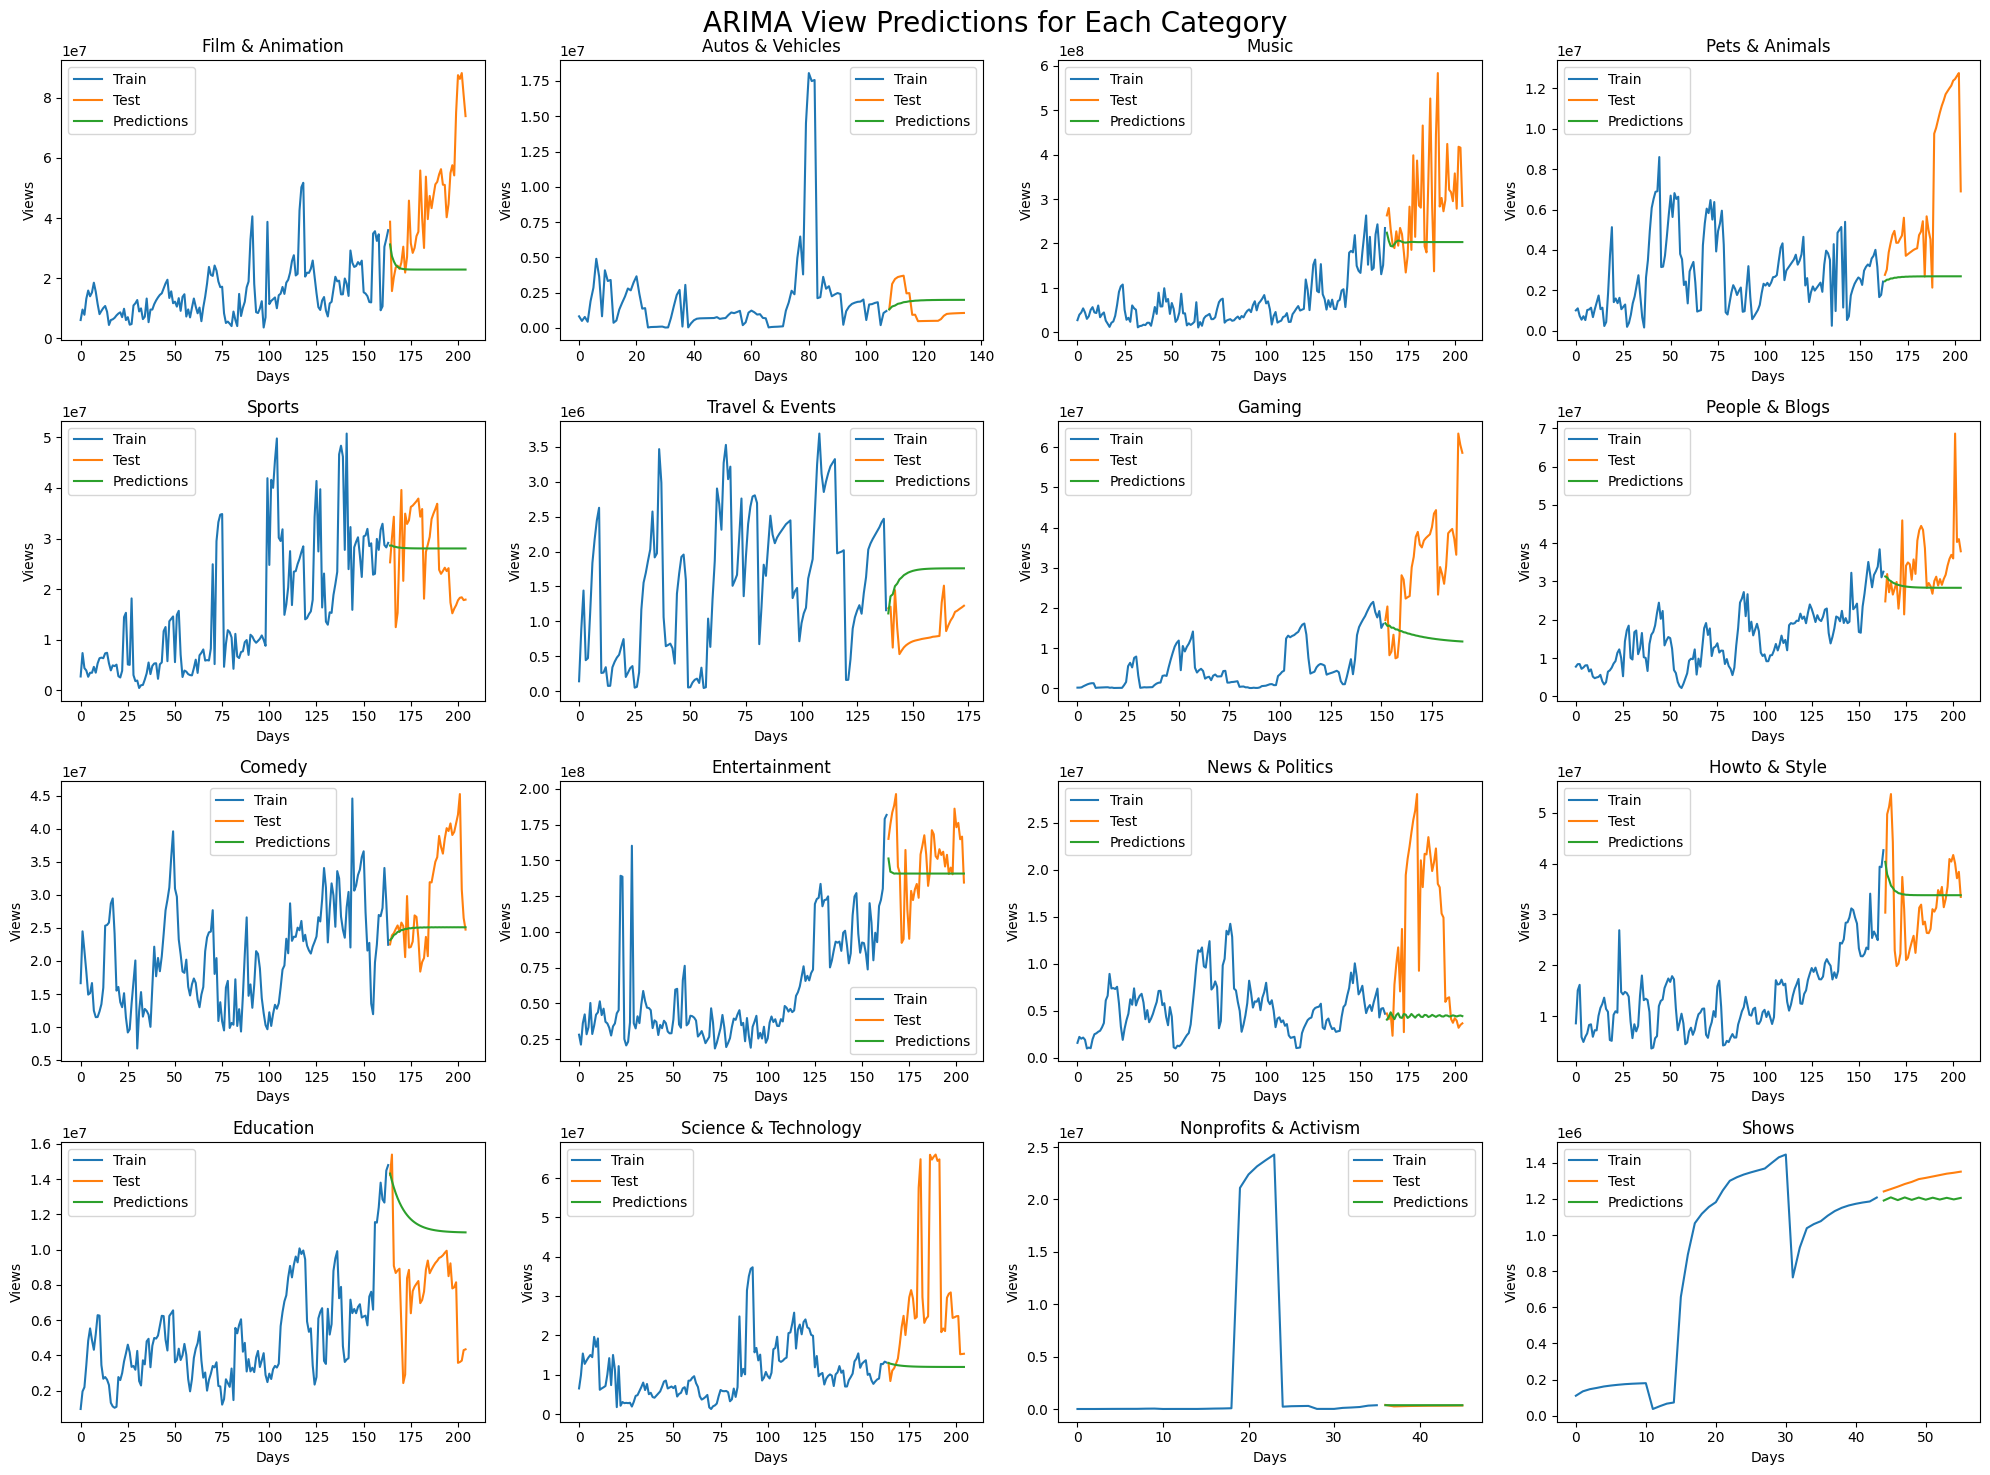

In [ ]:
future_predictions_ARIMA = {}
actual_trend_rise = {}
fig, axes = plt.subplots(4, 4, figsize=(20, 15))

for i in range(4):
  for j in range(4):
    id = i * 4 + j

    # Get category information
    cat_id, cat_name = combined_df.iloc[id, :]['category_id'].values[0], combined_df.iloc[id, :]['category'].values[0]

    # Filter data for the current category and prepare for time series
    cur_data = data[(data['category_id'] == cat_id)].reset_index()

    # Pivot and sort data by days_since_start
    views_num_days = pd.pivot_table(cur_data,index='days_since_start', values='views',aggfunc='sum').reset_index().sort_values(by='views')
    views_num_days = views_num_days.sort_values(by='days_since_start')

    # Split data into training and testing sets
    train_data = views_num_days[:int(len(views_num_days)*0.8)]
    test_data = views_num_days[int(len(views_num_days)*0.8):]
    X_train = train_data["days_since_start"].to_numpy().reshape(-1,1)
    Y_train = train_data["views"].to_numpy()
    X_test = test_data["days_since_start"].to_numpy().reshape(-1,1)
    Y_test = test_data["views"].to_numpy()

    # Fit the ARIMA model
    arima_order = (2, 1, 2)
    model = ARIMA(Y_train, order=arima_order)
    model_fit = model.fit()

    # Make and store predictions
    predictions = model_fit.forecast(steps=len(X_test))
    future_predictions_ARIMA[cat_name] = predictions
    actual_trend_rise[cat_name] = (Y_test[:14].mean() - Y_train[-13:].mean()) / Y_test[:14].mean()

    # Plotting
    ax = axes[i, j]
    ax.plot(Y_train, label='Train')
    ax.plot(range(len(Y_train), len(Y_train) + len(Y_test)), Y_test, label='Test')
    ax.plot(range(len(Y_train), len(Y_train) + len(Y_test)), predictions, label='Predictions')
    ax.set_title(f'{cat_name}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Views')
    ax.legend()

fig.suptitle('ARIMA View Predictions for Each Category', fontsize=20)
plt.tight_layout()
plt.show()

# SARIMA

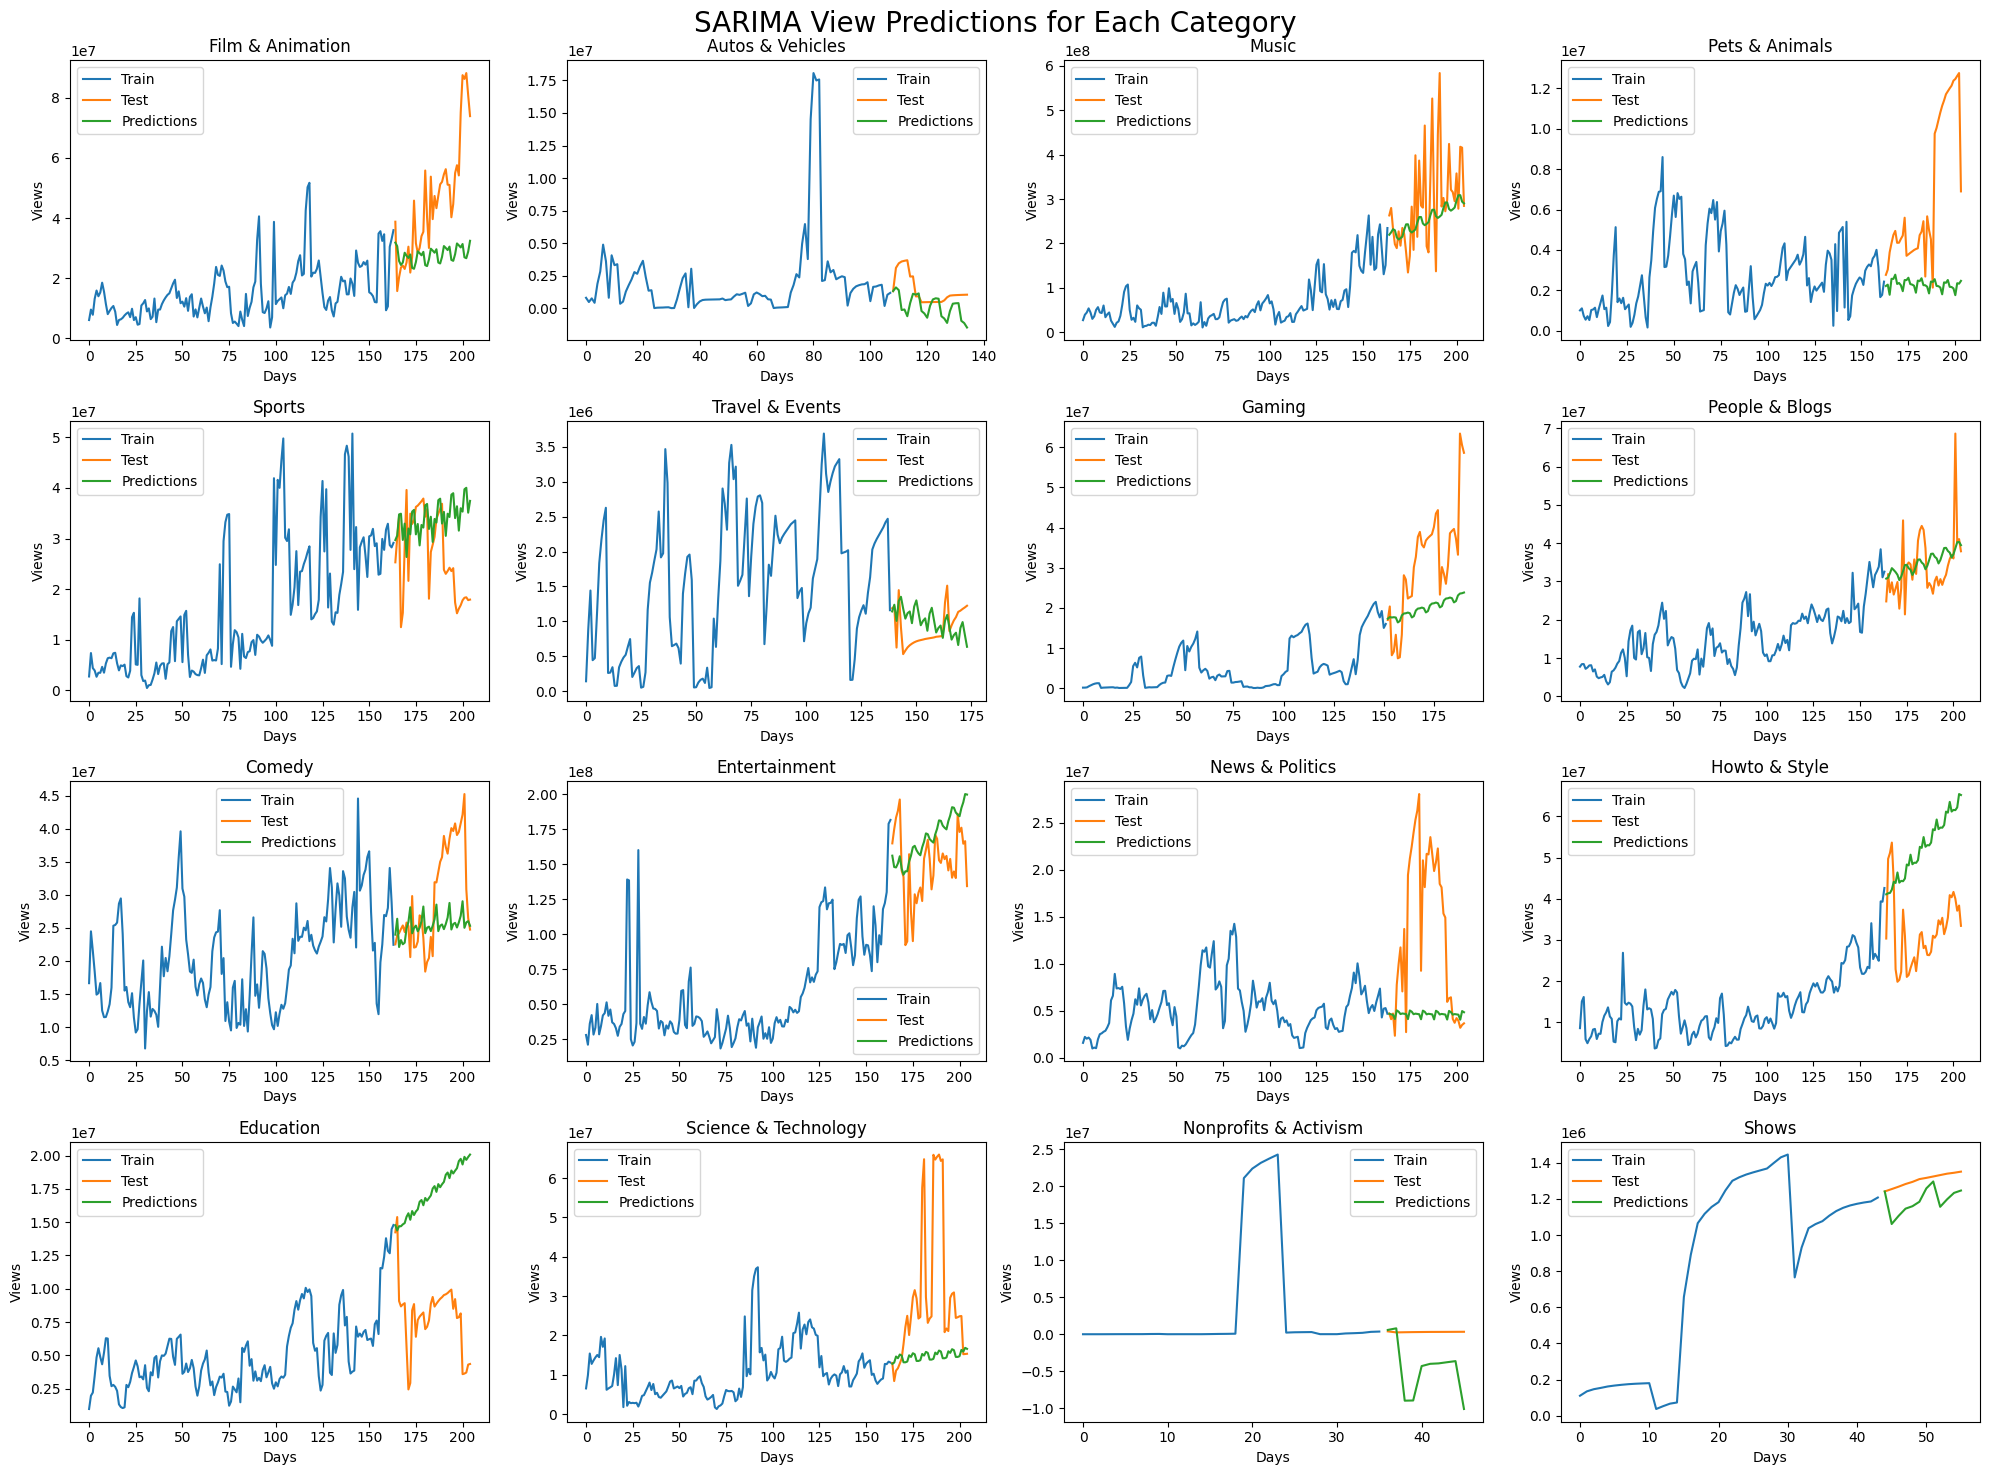

In [ ]:
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

future_predictions_SARIMA = {}
actual_trend_rise_SARIMA = {}

fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.flatten()


for i in range(len(combined_df)):
    # Get category information
    cat_id, cat_name = combined_df.iloc[i, :]['category_id'].values[0], combined_df.iloc[i, :]['category'].values[0]

    # Filter data for the current category and prepare for time series
    cur_data = data[(data['category_id'] == cat_id)].reset_index()

    # Pivot and sort data by days_since_start
    views_num_days = pd.pivot_table(cur_data, index='days_since_start', values='views', aggfunc='sum').reset_index().sort_values(by='days_since_start')

    # Split data into training and testing sets
    train_size = int(len(views_num_days) * 0.8)
    train_data = views_num_days[:train_size]
    test_data = views_num_days[train_size:]

    # Extract the 'views' column as the time series for SARIMA
    Y_train = train_data["views"].to_numpy()
    Y_test = test_data["views"].to_numpy()

    # Fit the SARIMA model
    model = SARIMAX(Y_train, order=sarima_order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    # Make and store predictions
    predictions = model_fit.forecast(steps=len(Y_test))
    future_predictions_SARIMA[cat_name] = predictions


    # Plotting
    ax = axes[i]
    ax.plot(Y_train, label='Train')
    ax.plot(range(len(Y_train), len(Y_train) + len(Y_test)), Y_test, label='Test')
    ax.plot(range(len(Y_train), len(Y_train) + len(Y_test)), predictions, label='Predictions')

    ax.set_title(f'{cat_name}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Views')
    ax.legend()

fig.suptitle('SARIMA View Predictions for Each Category', fontsize=20)
plt.tight_layout()
plt.show()

# LSTM

In [6]:
# Helper function to create sequences for univariate input
def df_to_X_y(df, window_size=5):
  df2 = df.set_index('days_since_start', inplace=False)
  df_as_np = df2.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = df_as_np[i:i+window_size]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

# Helper function to create sequences for multivariate input
def df_to_X_y_multivariate(df, window_size=5, target_column_index=0):
    X = []
    y = []
    for i in range(len(df) - window_size):
        row = df[i:i + window_size, :]
        X.append(row)
        label = df[i + window_size, target_column_index]
        y.append(label)
    return np.array(X), np.array(y)

In [ ]:
def train_lstm_for_category(data=data, window_size=5, cat_id=1, cat_name='', lagged=7, moving_avg=7, verbose_stopping=0, verbose_model=0):

    # Get category name if not provided
    if not cat_name:
        cat_name = combined_df[combined_df['category_id'] == cat_id]['category'].iloc[0]

    cur_data = data[(data['category_id'] == cat_id)].reset_index()

    views_num_days = pd.pivot_table(
        cur_data, index='days_since_start', values='views', aggfunc='sum'
    ).reset_index().sort_values(by='days_since_start')

    # Date for Day of Week
    min_actual_date = cur_data['trending_date'].min()
    views_num_days['date'] = views_num_days['days_since_start'].apply(
        lambda x: min_actual_date + dt.timedelta(days=x)
    )
    views_num_days['day_of_week'] = views_num_days['date'].dt.dayofweek
    views_num_days = pd.get_dummies(views_num_days, columns=['day_of_week'], prefix='DOW', drop_first=True)
    views_num_days.drop('date', axis=1, inplace=True)

    # Lagged Views and Moving Average
    views_num_days[f'views_lag_{lagged}'] = views_num_days['views'].shift(lagged)
    views_num_days[f'views_MA_{moving_avg}'] = views_num_days['views'].rolling(window=moving_avg).mean()

    views_num_days.dropna(inplace=True)
    views_num_days.reset_index(drop=True, inplace=True)

    if views_num_days.empty or len(views_num_days) < window_size + 15:
        print(f"Not enough data for category {cat_name} (ID: {cat_id}) after feature engineering.")
        return

    target_col = 'views'
    feature_cols = [col for col in views_num_days.columns if col not in ['days_since_start', target_col]]
    ordered_cols = [target_col] + feature_cols
    processed_df = views_num_days[ordered_cols]
    target_col_ind = 0

    # Train/Val/Test split
    split_idx = int(len(processed_df) * 0.80)

    train_df = processed_df[:split_idx]
    test_df = processed_df[split_idx:]

    if len(test_df) < window_size:
        print(f"Not enough data for validation/test split for category {cat_name} (ID: {cat_id}).")
        return

    X_train_df = train_df[feature_cols]
    y_train_df = train_df[[target_col]]

    X_test_df = test_df[feature_cols]
    y_test_df = test_df[[target_col]]

    # Initialize scalers
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    # Fit scalers only on train data and transform on test set
    X_train_scaled = scaler_X.fit_transform(X_train_df)
    y_train_scaled = scaler_y.fit_transform(y_train_df)

    X_test_scaled = scaler_X.transform(X_test_df)
    y_test_scaled = scaler_y.transform(y_test_df)

    # Combine scaled features and target back for sequence generation
    train_scaled = np.hstack([y_train_scaled, X_train_scaled])  # target first to match target_col_ind=0
    test_scaled = np.hstack([y_test_scaled, X_test_scaled])

    # Create sequences with df_to_X_y_multivariate
    X_train, Y_train = df_to_X_y_multivariate(train_scaled, window_size, target_col_ind)
    X_test, Y_test = df_to_X_y_multivariate(test_scaled, window_size, target_col_ind)

    num_features = X_train.shape[2]

    # Build LSTM model
    model = Sequential()
    model.add(InputLayer((window_size, num_features)))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')


    early_stopping = EarlyStopping(
        monitor='val_loss', patience=3,
        restore_best_weights=True,
        verbose=verbose_stopping
    )

    print(f"Training LSTM for category: {cat_name} (ID: {cat_id}).")
    model.fit(
        X_train, Y_train,
        epochs=120,
        batch_size=16,
        validation_split=0.15,
        callbacks=[early_stopping],
        verbose=verbose_model
    )

    predictions_scaled = model.predict(X_test)
    predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).ravel()

    Y_train_inversed = scaler_y.inverse_transform(Y_train.reshape(-1, 1)).ravel()
    Y_test_inversed = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).ravel()

    return Y_train_inversed, Y_test_inversed, predictions

### Multivariate Input

Training LSTM for category: Film & Animation (ID: 1).
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Training LSTM for category: Autos & Vehicles (ID: 2).
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
Training LSTM for category: Music (ID: 10).
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
Training LSTM for category: Pets & Animals (ID: 15).


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 892ms/step
Training LSTM for category: Sports (ID: 17).
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step
Training LSTM for category: Travel & Events (ID: 19).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
Training LSTM for category: Gaming (ID: 20).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Training LSTM for category: People & Blogs (ID: 22).
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step
Training LSTM for category: Comedy (ID: 23).
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
Training LSTM for category: Entertainment (ID: 24).
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
Training LSTM for category: News & Politics (ID: 25).
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
Training LSTM for category: Howto & Style (ID: 26).
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
Training LSTM for category: Education (ID: 27).
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
Training LSTM for category: Science & Technology (ID: 28).
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step
Training LSTM for category: Nonprofits & Activism (ID: 29).
1/1 

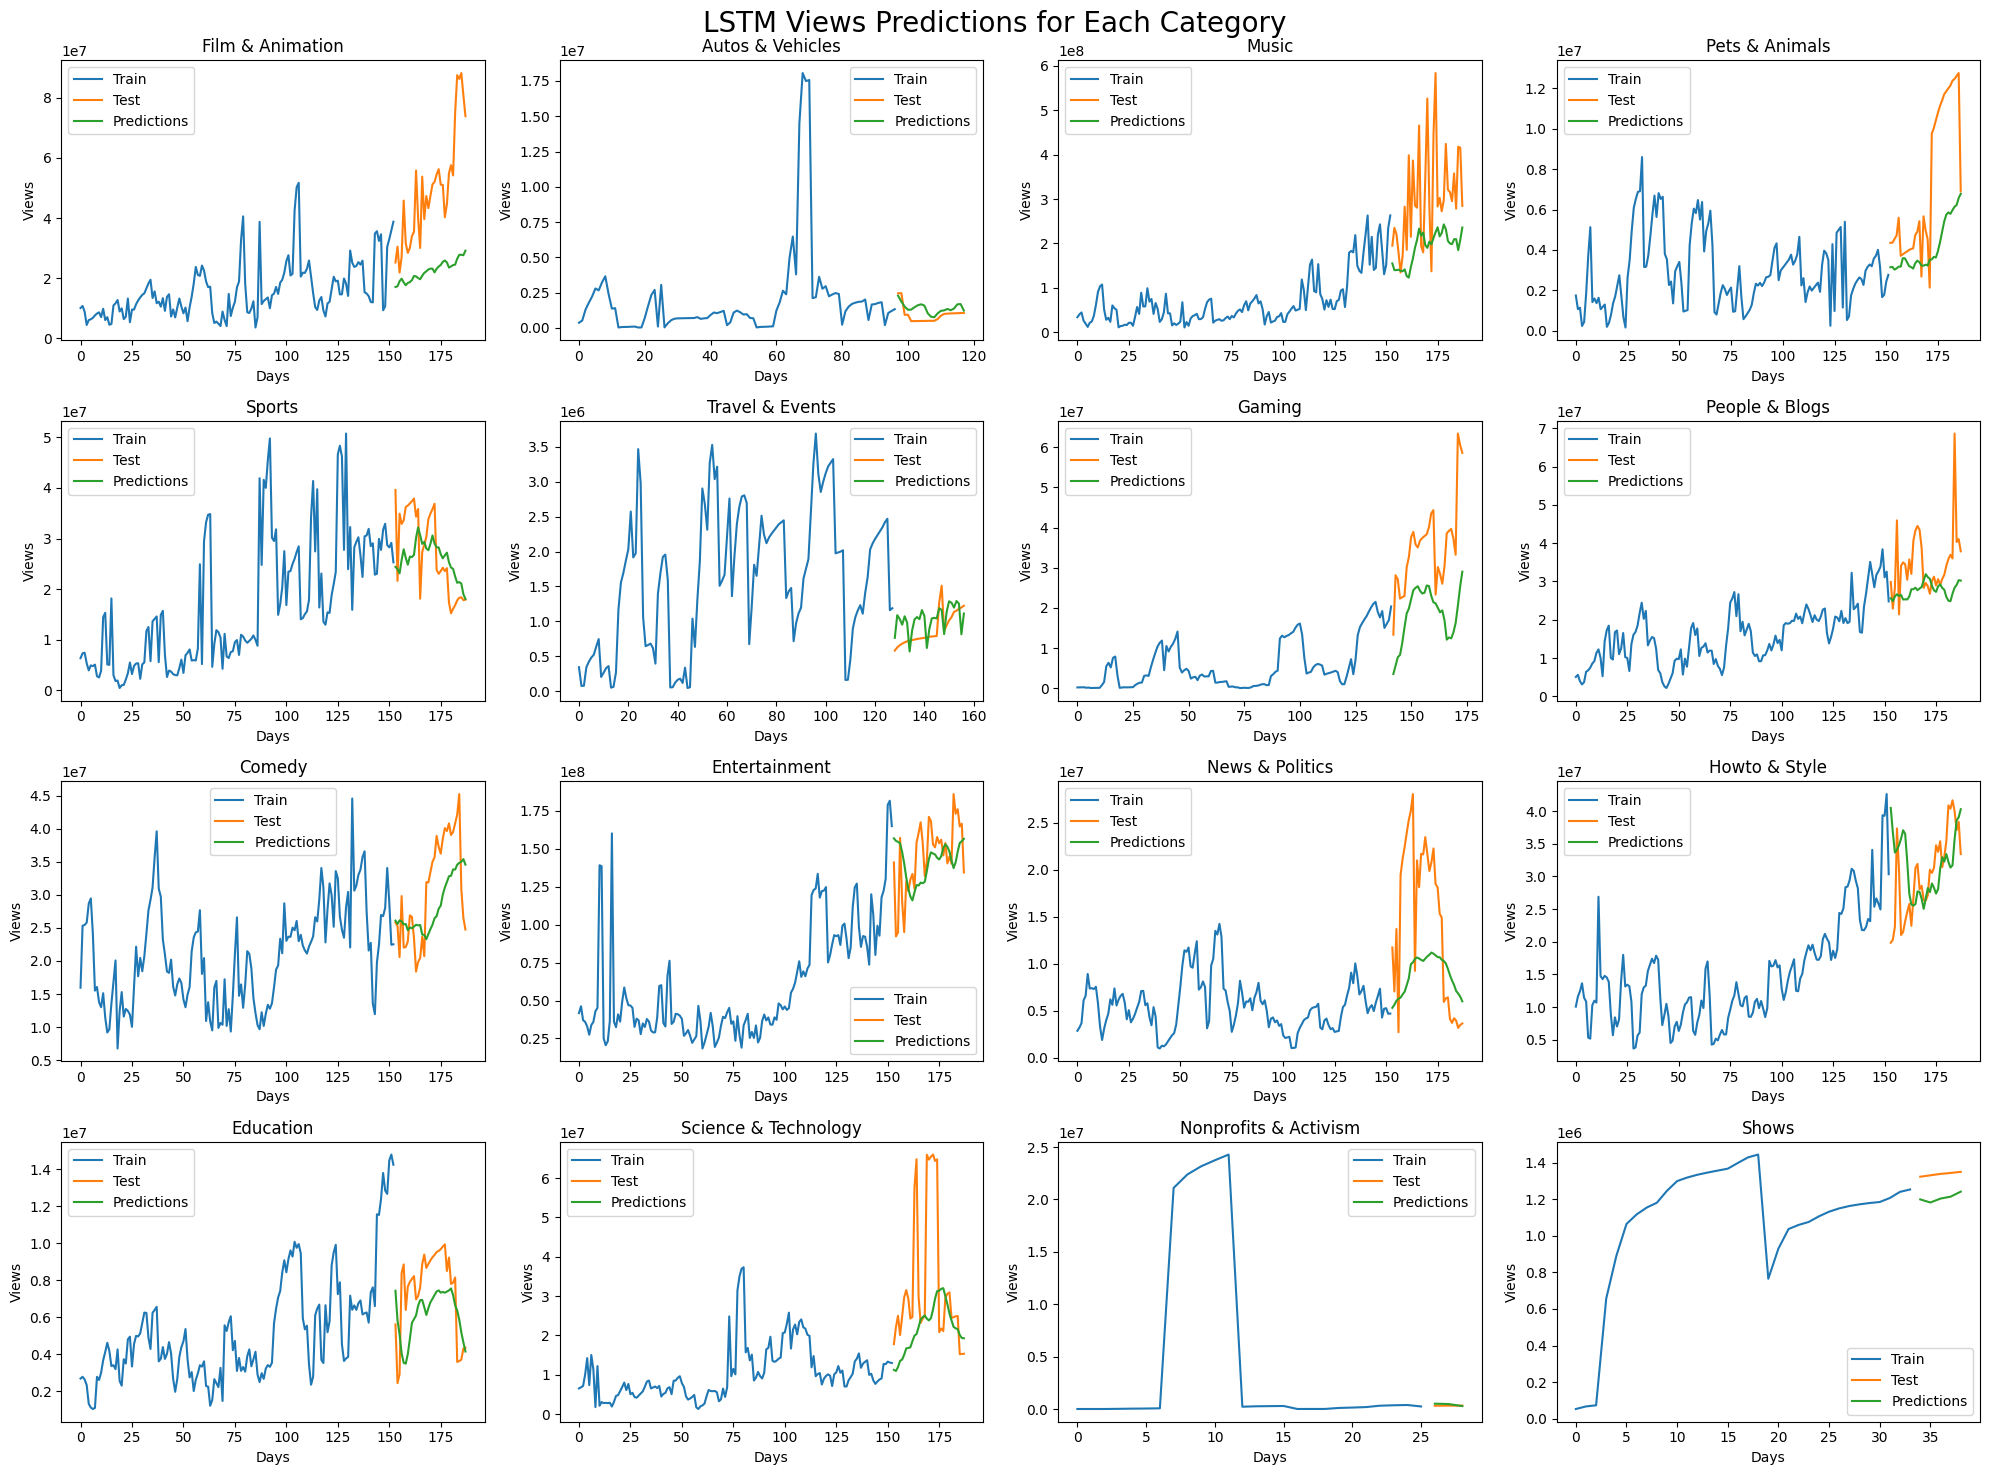

In [ ]:
lstm_future_predictions = {}
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
window_size=5
for i in range(4):
  for j in range(4):
    id = i * 4 + j
    cat_id, cat_name = combined_df.iloc[id, :]['category_id'].values[0], combined_df.iloc[id, :]['category'].values[0]
    Y_train_inversed, Y_test_inversed, predictions = train_lstm_for_category(data, window_size=window_size, cat_id=cat_id, cat_name=cat_name, lagged=7, moving_avg=7, verbose_stopping=0, verbose_model=0)
    lstm_future_predictions[cat_name] = predictions
    ax = axes[i, j]
    ax.plot(Y_train_inversed, label='Train')
    ax.plot(np.arange(len(Y_train_inversed), len(Y_train_inversed) + len(Y_test_inversed)), Y_test_inversed, label='Test')
    ax.plot(np.arange(len(Y_train_inversed), len(Y_train_inversed) + len(Y_test_inversed)), predictions, label='Predictions')

    ax.set_title(f'{cat_name}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Views')
    ax.legend()

fig.suptitle('LSTM Views Predictions for Each Category', fontsize=20)
plt.tight_layout()
plt.show()

Training LSTM for category: Film & Animation (ID: 1).
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step


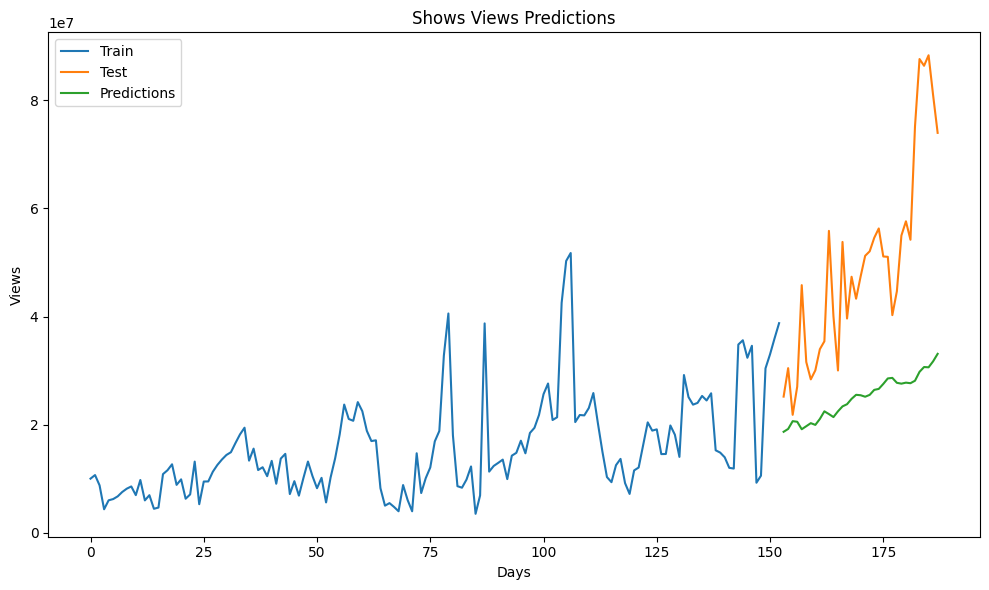

In [ ]:
Y_train_inversed, Y_test_inversed, predictions = train_lstm_for_category(data, window_size=window_size, cat_id=1, cat_name='', lagged=7, moving_avg=7, verbose_stopping=0, verbose_model=0)

fig, axes = plt.subplots(1,1, figsize=(10, 6))
ax = axes
ax.plot(np.arange(len(Y_train_inversed)), Y_train_inversed, label='Train')
ax.plot(np.arange(len(Y_train_inversed), len(Y_train_inversed) + len(Y_test_inversed)), Y_test_inversed, label='Test')
ax.plot(np.arange(len(Y_train_inversed), len(Y_train_inversed) + len(Y_test_inversed)), predictions, label='Predictions')

ax.set_title(f'{cat_name} Views Predictions')
ax.set_xlabel('Days')
ax.set_ylabel('Views')
ax.legend()

plt.tight_layout()
plt.show()

### Univariate Input

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


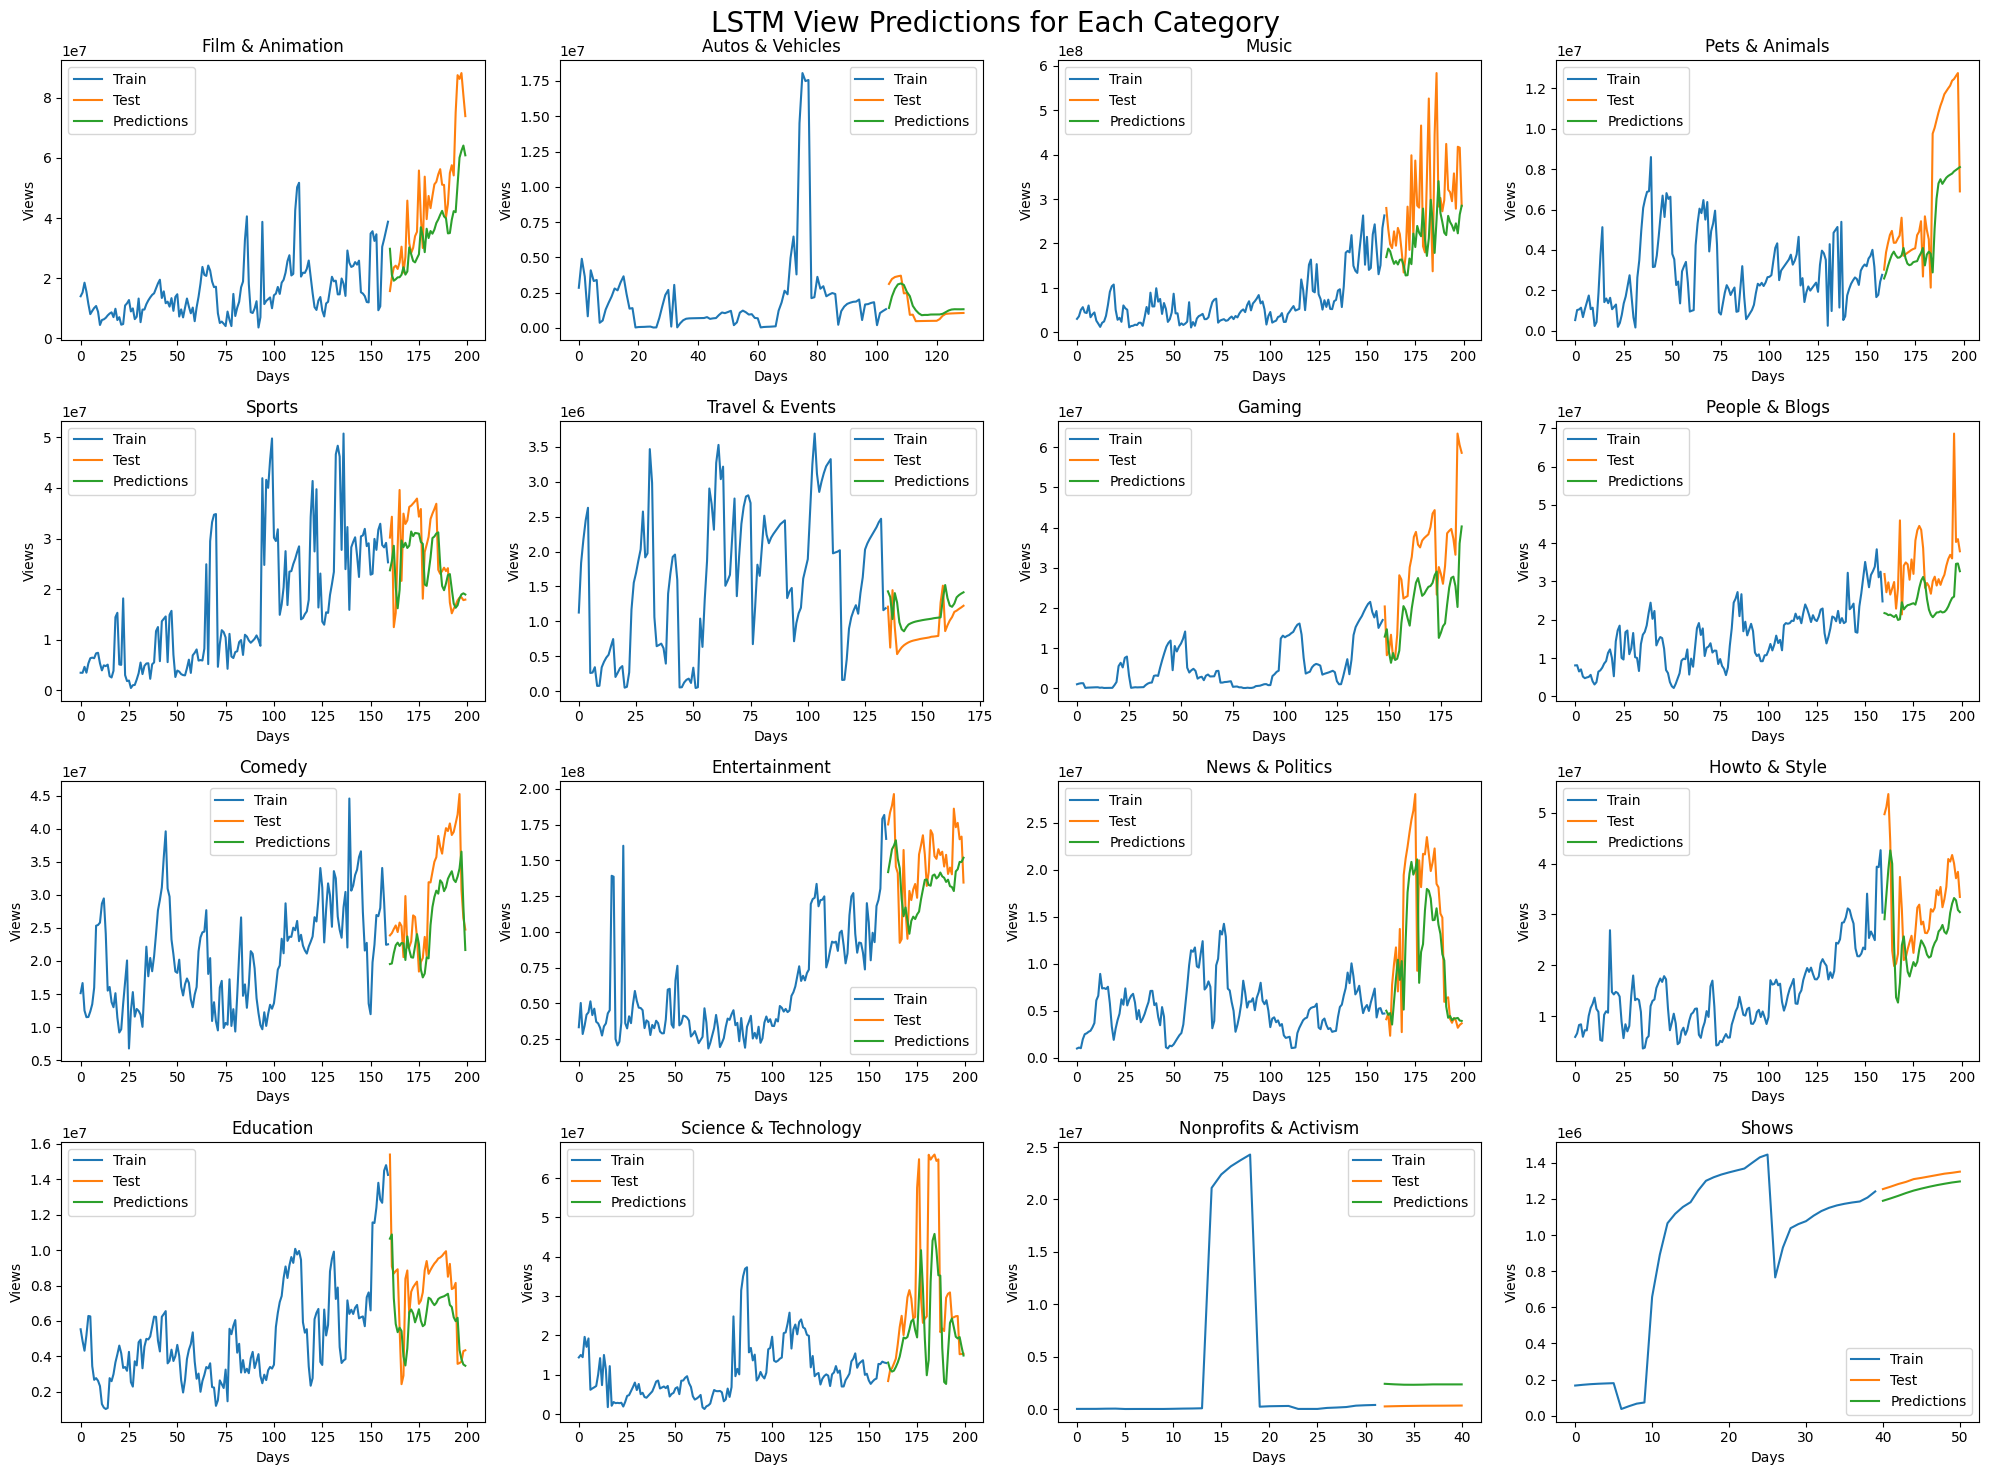

In [7]:
lstm_future_predictions = {}
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
window_size=5
for i in range(4):
  for j in range(4):
    id = i * 4 + j
    cat_id, cat_name = combined_df.iloc[id, :]['category_id'].values[0], combined_df.iloc[id, :]['category'].values[0]
    cur_data = data[(data['category_id'] == cat_id)].reset_index()

    views_num_days = pd.pivot_table(cur_data,index='days_since_start', values='views',aggfunc='sum').reset_index().sort_values(by='views')
    views_num_days = views_num_days.sort_values(by='days_since_start')

    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_Y = MinMaxScaler(feature_range=(0, 1))

    X, y = df_to_X_y(views_num_days, window_size)
    train_size = int(len(X) * 0.8)
    X_train, Y_train = X[:train_size], y[:train_size]
    X_test, Y_test = X[train_size:], y[train_size:]

    # Reshape X_train and X_test to 2D for scaling
    X_train_shape = X_train.shape
    X_train_2D = X_train.reshape(X_train_shape[0], -1)

    X_test_shape = X_test.shape
    X_test_2D = X_test.reshape(X_test_shape[0], -1)

    # Scale the 2D arrays
    X_train_scaled_2D = scaler_X.fit_transform(X_train_2D)
    X_test_scaled_2D = scaler_X.transform(X_test_2D)

    # Reshape the scaled data back to 3D for the LSTM model
    X_train_scaled = X_train_scaled_2D.reshape(X_train_shape)
    X_test_scaled = X_test_scaled_2D.reshape(X_test_shape)

    # Scale the target variable
    Y_train_scaled = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
    Y_test_scaled = scaler_Y.transform(Y_test.reshape(-1, 1))

    model = Sequential()
    model.add(InputLayer((window_size, 1)))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train_scaled, Y_train_scaled, validation_split=0.15, epochs=50, batch_size=16, verbose=0)

    predictions_scaled = model.predict(X_test_scaled)
    predictions = scaler_Y.inverse_transform(predictions_scaled)


    lstm_future_predictions[cat_name] = predictions
    ax = axes[i, j]
    ax.plot(Y_train, label='Train')
    ax.plot(range(len(Y_train), len(Y_train) + len(Y_test)), Y_test, label='Test')
    ax.plot(range(len(Y_train), len(Y_train) + len(Y_test)), predictions, label='Predictions')
    ax.set_title(f'{cat_name}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Views')
    ax.legend()

fig.suptitle('LSTM View Predictions for Each Category', fontsize=20)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


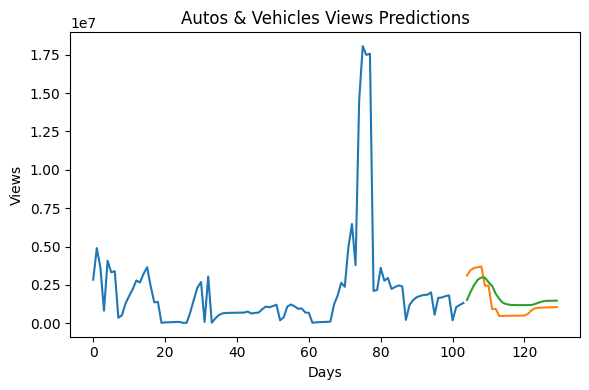

In [17]:
window_size = 5
cat_id = 2
cat_name = category_ids[id]
cur_data = data[(data['category_id'] == cat_id)].reset_index()

views_num_days = pd.pivot_table(cur_data,index='days_since_start', values='views',aggfunc='sum').reset_index().sort_values(by='views')
views_num_days = views_num_days.sort_values(by='days_since_start')

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X, y = df_to_X_y(views_num_days, window_size)
train_size = int(len(X) * 0.8)
X_train, Y_train = X[:train_size], y[:train_size]
X_test, Y_test = X[train_size:], y[train_size:]

# Reshape X_train and X_test to 2D for scaling
X_train_shape = X_train.shape
X_train_2D = X_train.reshape(X_train_shape[0], -1)

X_test_shape = X_test.shape
X_test_2D = X_test.reshape(X_test_shape[0], -1)

# Scale the 2D arrays
X_train_scaled_2D = scaler_X.fit_transform(X_train_2D)
X_test_scaled_2D = scaler_X.transform(X_test_2D)

# Reshape the scaled data back to 3D for the LSTM model
X_train_scaled = X_train_scaled_2D.reshape(X_train_shape)
X_test_scaled = X_test_scaled_2D.reshape(X_test_shape)

# Scale the target variable
Y_train_scaled = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
Y_test_scaled = scaler_Y.transform(Y_test.reshape(-1, 1))

model = Sequential()
model.add(InputLayer((window_size, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train_scaled, Y_train_scaled, epochs=50, batch_size=16, verbose=0)

predictions_scaled = model.predict(X_test_scaled)
predictions = scaler_Y.inverse_transform(predictions_scaled)

fig, axes = plt.subplots(1,1, figsize=(6, 4))
ax = axes
ax.plot(Y_train, label='Train')
ax.plot(range(len(Y_train), len(Y_train) + len(Y_test)), Y_test, label='Test')
ax.plot(range(len(Y_train), len(Y_train) + len(Y_test)), predictions, label='Predictions')
ax.set_title(f'{cat_name} Views Predictions')
ax.set_xlabel('Days')
ax.set_ylabel('Views')

plt.tight_layout()
plt.show()

In [18]:
# percent of rise
(Y_test[:14].mean() - Y_train[-13:].mean()) / Y_test[:14].mean()

np.float64(0.24494065004971396)